In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


from bayesmixpy import build_bayesmix, run_mcmc

In [2]:
build_bayesmix(4)

Building the Bayesmix executable
CMAKE_MODULE_PATH /Users/dariabystrova/bayesmix
-- downloading/updating math
-- math directory found, pulling...
From https://github.com/bayesmix-dev/math
* branch                  master     -> FETCH_HEAD
--
Already on 'develop'
-- Your branch is ahead of 'origin/develop' by 22 commits.
(use "git push" to publish your local commits)

-- Using math TBB
-- Building Intel TBB: /usr/bin/make -j12 stdver=c++17 compiler=clang tbb_build_dir=/Users/dariabystrova/bayesmix/lib/math/lib/tbb tbb_build_prefix=tbb
FINDPROTOBUF:CMAKE Protobuf_FOUND 0
FINDPROTOBUF:CMAKE PROTOBUF_FOUND 1
-- protoc proto(cc): /Users/dariabystrova/bayesmix/src/proto/algorithm_id.proto
-- protoc hdr: /Users/dariabystrova/bayesmix/build/algorithm_id.pb.h
-- protoc src: /Users/dariabystrova/bayesmix/build/algorithm_id.pb.cc
-- protoc proto(cc): /Users/dariabystrova/bayesmix/src/proto/algorithm_params.proto
-- protoc hdr: /Users/dariabystrova/bayesmix/build/algorithm_params.pb.h
-- protoc sr

True

In [3]:
from google.protobuf.internal.decoder import _DecodeVarint32

In [172]:
def readManyFromFile(filename, msgType):
    out = []
    with open(filename, "rb") as fp:
        buf = fp.read()

    n = 0
    while n < len(buf):
        msg_len, new_pos = _DecodeVarint32(buf, n)
        n = new_pos
        msg_buf = buf[n:n+msg_len]
        try:
            msg = msgType()
            msg.ParseFromString(msg_buf)
            out.append(msg)
            n += msg_len
        except Exception as e:
            break

    return np.array(out)

#chainfiles = ["chains.recordio",]
#chains = readManyFromFile(chainfiles[0], DPState)[-1000:]
#c_chain = np.vstack([x.c for x in chains if len(x.c)])


In [170]:
#Data
data1 = np.loadtxt("../scripts_for_figures/sim_data/GM_3_20.csv", delimiter=",",skiprows=1)
data2 = np.loadtxt("../scripts_for_figures/sim_data/GM_3_200.csv", delimiter=",",skiprows=1,usecols = (1,2))
data3 = np.loadtxt("../scripts_for_figures/sim_data/GM_3_2000.csv", delimiter=",",skiprows=1,usecols = (1,2))
data4 = np.loadtxt("../scripts_for_figures/sim_data/GM_3_20000.csv",delimiter=",",skiprows=1)

In [171]:
n_components = 10
alpha = 0.1
e0= 1/10

$\frac{\alpha}{N}$

In [172]:
beta_alpha1 = np.ones(n_components)*e0
beta_alpha2 = np.ones(n_components)

for x in range(10):
    beta_alpha2[x] = e0*(n_components - (x+1))

In [173]:
#beta_alpha2

In [174]:
beta_params_template = """
beta_distributions {{
    shape_a: {0}
    shape_b: {1}
}}
"""

beta_params_proto = [
    beta_params_template.format(a1, a2) for a1, a2 in zip(beta_alpha1, beta_alpha2)
]


trunc_sb_params = """
num_components: {0}
beta_priors {{
    {1}
}}
""".format(n_components, "".join(beta_params_proto))

In [134]:
g0_params_fix = """
fixed_values {
    mean: 0.0
    var_scaling: 0.1
    shape: 2.0
    scale: 2.0
}
"""

neal2_algo = """
algo_id: "BlockedGibbs"
rng_seed: 20201124
iterations: 2000
burnin: 1000
init_num_clusters: 3
"""

In [135]:
dens_grid = np.linspace(-10, 10, 1000)
data = np.concatenate([
    np.random.normal(loc=3, scale=1, size=100),
    np.random.normal(loc=-3, scale=1, size=100),
])
eval_dens, clust, n_clust, p_clust = run_mcmc(
    "NNIG", "TruncSB", data, g0_params_fix, trunc_sb_params, neal2_algo, dens_grid,
    return_clusters=True, return_num_clusters=True,
    return_best_clus=True)

Running run_mcmc.cc
Creating MemoryCollector
Initializing... Done
Running BlockedGibbs algorithm with NNIG hierarchies, TruncSB mixing...
[============================================================] 100% 0.82s                                                                                       Done
Computing log-density...
Successfully wrote density to /var/folders/2z/0sxx_8ts2pxcp028sy41wfgc0000gn/T/tmpptzqvp6v/eval_dens.csv
Successfully wrote number of clusters to /var/folders/2z/0sxx_8ts2pxcp028sy41wfgc0000gn/T/tmpptzqvp6v/n_clus.csv
Successfully wrote cluster allocations to /var/folders/2z/0sxx_8ts2pxcp028sy41wfgc0000gn/T/tmpptzqvp6v/clus.csv
(Computing mean dissimilarity... Done)
Computing Frobenius norm error...
[===>                                                        ] 5% 0.017s                     

In [139]:
np.unique(n_clust[1])

array([2., 4., 5., 7.])

In [ ]:
clust

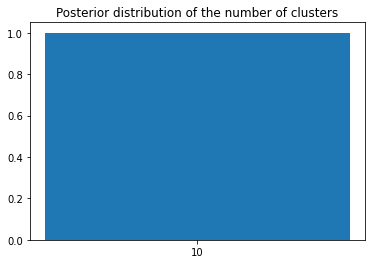

In [137]:
x, y = np.unique(clust, return_counts=True)
plt.bar(x, y / y.sum())
plt.xticks(x)
plt.title("Posterior distribution of the number of clusters")
plt.show()

# Dirichlet multinomial mixture: multivariate case

In [141]:
g0_params_fix = """
fixed_values {
    mean {
        size: 2
        data: 3.484
        data: 3.487
    }
    var_scaling: 0.01
    deg_free: 5
    scale {
        rows: 2
        cols: 2
        data: 1.0
        data: 0.0
        data: 0.0
        data: 1.0
        rowmajor: false
    }
}
"""

neal2_algo = """
algo_id: "BlockedGibbs"
rng_seed: 20201124
iterations: 2000
burnin: 1000
init_num_clusters: 3
"""


In [142]:
xgrid = np.linspace(-2, 2, 50)
xgrid, ygrid = np.meshgrid(xgrid, xgrid)
dens_grid = np.hstack([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)])

In [147]:
eval_dens, clust, n_clust, p_clust = run_mcmc(
    "NNW", "TruncSB", data2, g0_params_fix, trunc_sb_params, neal2_algo, dens_grid,
    return_clusters=True, return_num_clusters=True,
    return_best_clus=True)

Running run_mcmc.cc
Creating MemoryCollector
Initializing... Done
Running BlockedGibbs algorithm with NNW hierarchies, TruncSB mixing...
[============================================================] 100% 2.148s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Done
Computing log-density...
Successfully wrote density to /var/folders/2z/0sxx_8ts2pxcp028sy41wfgc0000gn/T/tmpzuvv3opj/eval_dens.csv
Successfully wrote number of clusters to /var/folders/2z/0sxx_8ts2pxcp028sy41wfgc0000gn/T/tmpzuvv3opj/n_clus.csv
Successfully wrote cluster allocations to /var/folders/2z/0sxx_8ts2px

In [148]:
np.unique(n_clust[1])

array([1., 6.])

In [149]:
n_clust.shape

(1000, 200)

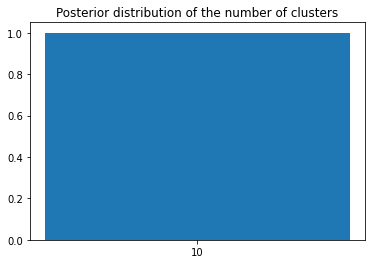

In [150]:
x, y = np.unique(clust, return_counts=True)
plt.bar(x, y / y.sum())
plt.xticks(x)
plt.title("Posterior distribution of the number of clusters")
plt.show()

# DP process mixture: multivariate case

In [156]:
data3
mu0 = np.mean(data2, axis=0)
mu0
xgrid = np.linspace(-2, 2, 50)
xgrid, ygrid = np.meshgrid(xgrid, xgrid)
dens_grid = np.hstack([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)])

In [166]:
mu0

array([0.43783005, 0.27623514])

In [175]:
dp_params = """
fixed_value {
    totalmass: 1.
}
"""

py_params = """
fixed_values {
    strength: 1.0
    discount: 0.2
}
"""


g0_params = """
fixed_values {
    mean {
        size: 2
        data: 0.437
        data: 0.27
    }
    var_scaling: 0.5
    deg_free: 5
    scale {
        rows: 2
        cols: 2
        data: 1.0
        data: 0.0
        data: 0.0
        data: 1.0
        rowmajor: false
    }
}
"""

neal2_algo = """
algo_id: "Neal2"
rng_seed: 20201124
iterations: 10000
burnin: 3000
init_num_clusters: 3
"""

In [176]:
eval_dens_dp, clust, n_clust, best_clus_dp = run_mcmc(
    "NNW", "DP", data3, g0_params, dp_params, neal2_algo, 
    dens_grid, return_clusters=True, return_num_clusters=True,
    return_best_clus=True)



Running run_mcmc.cc
Creating MemoryCollector
Initializing... Done
Running Neal2 algorithm with NNW hierarchies, DP mixing...
[============================================================] 100% 122.88s                                                                                                                                        Done
Computing log-density...
Successfully wrote density to /var/folders/2z/0sxx_8ts2pxcp028sy41wfgc0000gn/T/tmpllo8918p/eval_dens.csv
Successfully wrote number of clusters to /var/folders/2z/0sxx_8ts2pxcp028sy41wfgc0000gn/T/tmpllo8918p/n_clus.csv
Successfully wrote cluster allocations to /var/folders/2z/0sxx_8ts2pxcp028sy41wfgc0000gn/T/tmpllo8918p/clus.csv
(Computing mean dissimilarity... Done)
Computing Frobenius norm error...
[============================================================] 100% 169.204s                                                                    Done
Successfully wrote best cluster allocations to /var/folders/2z/0sxx_8ts2pxcp028sy4

In [165]:
np.unique(n_clust[1])

array([0., 1., 2.])

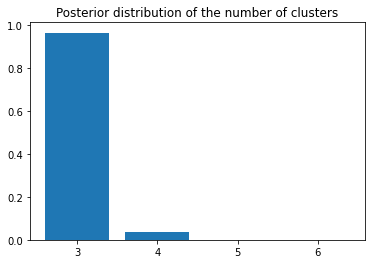

In [164]:
x, y = np.unique(clust, return_counts=True)
plt.bar(x, y / y.sum())
plt.xticks(x)
plt.title("Posterior distribution of the number of clusters")
plt.show()

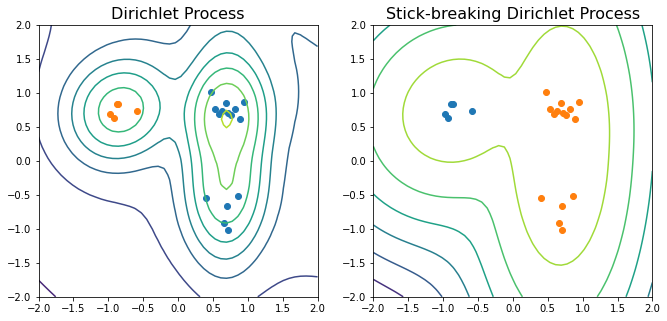

In [132]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

mean_dens_dp = np.mean(eval_dens_dp, axis=0)
mean_dens_py = np.mean(eval_dens, axis=0)

axes[0].set_title("Dirichlet Process", fontsize=16)
axes[0].contour(xgrid, ygrid, mean_dens_dp.reshape(xgrid.shape))
for c in np.unique(best_clus_dp):
    currdata = data1[best_clus_dp == c, :]
    axes[0].scatter(currdata[:, 0], currdata[:, 1])

axes[1].set_title("Stick-breaking Dirichlet Process", fontsize=16)
axes[1].contour(xgrid, ygrid, mean_dens_py.reshape(xgrid.shape))
for c in np.unique(p_clust):
    currdata = data1[p_clust == c, :]
    axes[1].scatter(currdata[:, 0], currdata[:, 1])

In [94]:
dp_params = """
fixed_value {
totalmass: 1.0
}
"""
g0_params = """
fixed_values {
mean: 0.0
var_scaling: 0.1
shape: 2.0
scale: 2.0
}
"""
algo_params = """
algo_id: "Neal2"
rng_seed: 20201124
iterations: 1500
burnin: 500
init_num_clusters: 3
"""


In [96]:
data = np.concatenate([np.random.normal(size=100) - 3,
np.random.normal(size=100) + 3])
dens_grid = np.linspace(-6, 6, 1000)
log_dens, numcluschain, cluschain, bestclus = run_mcmc(
"NNIG", "DP", data, g0_params, dp_params, algo_params,
dens_grid=dens_grid, return_clusters=True, return_num_clusters=True,
return_best_clus=True)

Running run_mcmc.cc
Creating MemoryCollector
Initializing... Done
Running Neal2 algorithm with NNIG hierarchies, DP mixing...
[============================================================] 100% 0.928s                                                                    Done
Computing log-density...
Successfully wrote density to /var/folders/2z/0sxx_8ts2pxcp028sy41wfgc0000gn/T/tmpq8b5x5vj/eval_dens.csv
Successfully wrote number of clusters to /var/folders/2z/0sxx_8ts2pxcp028sy41wfgc0000gn/T/tmpq8b5x5vj/n_clus.csv
Successfully wrote cluster allocations to /var/folders/2z/0sxx_8ts2pxcp028sy41wfgc0000gn/T/tmpq8b5x5vj/clus.csv
(Computing mean dissimilarity... Done)
Computing Frobenius norm error...
[=======>                                                    ] 12% 0.023s 